In [24]:
import numpy as np
import matplotlib.pyplot as plt

from fwz_msv_msre import *

# 1. Modelo com mudança de regime no parâmetro de política

In [37]:
# == Parâmetros do modelo original == #

# Coeficientes do modelo

tau    = [0.6137, 0.6137] 
kappa  = [0.6750, 0.6750] 
beta   = [0.9949, 0.9949] 
gamma1 = [2.1900, 0.7700] 
gamma2 = [0.2350, 0.2350] 


# Variância dos choques

rhoD   = [0.7550, 0.7550] 
rhoS   = [0.8350, 0.8350] 
rhoR   = [0.7200, 0.7200] 
sigmaD = [0.2250, 0.2250] 
sigmaS = [0.6206, 0.6206] 
sigmaR = [0.2050, 0.2050] 

# Matriz de transição

P = np.array([[1, 0.0128],
             [0, 0.9872]])

# == Matrizes == #

n = 7
h = 2
s = 2
n_choques = 3

A   = np.array([np.zeros((n,n)) for i in range(h)])
B   = np.array([np.zeros((n,n)) for i in range(h)])
Psi = np.array([np.zeros((n,n_choques)) for i in range(h)])
Pi  = np.array([np.zeros((n,s)) for i in range(h)])

for i in range(h):
    
    A[i][0,0] = 1
    A[i][1,0] = -kappa[i]
    A[i][2,0] = -(1-rhoR[i])*gamma2[i]
    A[i][5,0] = 1
    A[i][0,1] = -1
    A[i][1,2] = 1
    A[i][2,2] = -(1-rhoR[i])*gamma1[i]
    A[i][6,2] = 1
    A[i][0,3] = -tau[i]
    A[i][1,3] = -beta[i]
    A[i][0,4] = tau[i]
    A[i][2,4] = 1
    A[i][0,5] = -1
    A[i][3,5] = 1
    A[i][1,6] = 1
    A[i][4,6] = 1

    B[i][5,1] = 1
    B[i][6,3] = 1
    B[i][2,4] = rhoR[i]
    B[i][3,5] = rhoD[i]
    B[i][4,6] = rhoS[i]

    Psi[i][2,0] = 1
    Psi[i][3,1] = 1
    Psi[i][4,2] = 1
    
    Pi[i][5,0] = 1
    Pi[i][6,1] = 1

# == chute inicial == #
np.random.seed(1234)
x_inicial = np.random.normal(0,1,20).reshape((20,1))

## 1.1 Resolvendo o modelo

In [48]:
# Usa o método descrito em Farmer, Waggoner and Zha (2011)

resultado = fwz_msv_msre(P=P.T, A=A, B=B, Psi=Psi, s=s, x=x_inicial, max_count=1000, tol=1e-5)

F1 = resultado[0]
F2 = resultado[1]
G1 = resultado[2]
G2 = resultado[3]
V  = resultado[4]
err= resultado[5]

In [49]:
#pd.DataFrame(np.round(F1[0], decimals=4))

## 1.2 Verificando a estabilidade

In [50]:
if err<0:
    print("Não há equilíbrio MSV")
else:
    print('------------- Solução FWZ ------------')
    print('''Solução G1(j) para x_t = G1(j) x_{t-1} + G2(j) \epsilon_t,
             em que x_t = [x_t, E_t x_{t+1}, pi_t, E_t pi_{t+1}, R_t, z_{D,t}, z_{S,t}]'
             para ambos regimes:''')
    print('')
    G = np.array([np.zeros((n,n)) for j in range(h)])
    impact = np.array([np.zeros((n,n_choques)) for j in range(h)])

    for j in range(h):
        G[j] = np.dot(V[j], F1[j])
        print(pd.DataFrame(np.round(G[j], decimals=4)))
        print('')
    print('')
    print('')
    print('Matriz de impacto G2(j) sobre \epsilon_t para ambos os regimes:')
    print('')
    for j in range(h):
        impact[j] = np.dot(V[j], G1[j])
        print(pd.DataFrame(np.round(impact[j], decimals=4)))
        print('')
        
    # == Checando a estacionariedade da solução == #
    
    print(""" Checa a estacionariedade do modelo com mudança de regime.
    
    Se as linhas de P somam 1, e Gamma(i)=V(i)*A(i) é n x n, então a solução é estável em média quadrática
    se e somente se os autovalores de:
    
    kron(P',eye(n*n)) * diag(kron(Gamma(i),Gamma(i)))
    
    estão todos dentro do círculo unitário.""")
    
    stackblkdiag = np.zeros((h*n**2,h*n**2))
    
    for i in range(h):
        stackblkdiag[(i*n**2):(i+1)*n**2, (i*n**2):(i+1)*n**2] = np.kron(G[i], G[i])
    
    stackmat = np.dot(np.kron(P, np.eye(n*n)), stackblkdiag)
    autovalores, autovetores = np.linalg.eig(stackmat)
    print('')
    print('--------------------------------------------------------')
    print('Se o seguinte máximo autovalor em módulo for menor do que 1.0, então a solução é estacionária')
    
    print(max(np.round(np.abs(autovalores), decimals=4)))

------------- Solução FWZ ------------
Solução G1(j) para x_t = G1(j) x_{t-1} + G2(j) \epsilon_t,
             em que x_t = [x_t, E_t x_{t+1}, pi_t, E_t pi_{t+1}, R_t, z_{D,t}, z_{S,t}]'
             para ambos regimes:

     0    1    2    3       4       5       6
0  0.0  0.0  0.0  0.0 -0.5188  0.9189  0.8538
1  0.0  0.0  0.0  0.0 -0.1838  0.3394  0.8679
2  0.0  0.0  0.0  0.0 -0.5408  1.0155 -0.5788
3  0.0  0.0  0.0  0.0 -0.1916  0.3973 -0.3218
4  0.0  0.0  0.0  0.0  0.3543  0.6832 -0.2988
5  0.0  0.0  0.0  0.0  0.0000  0.7550  0.0000
6  0.0  0.0  0.0  0.0  0.0000  0.0000  0.8350

     0    1    2    3       4       5       6
0  0.0  0.0  0.0  0.0 -0.9358  1.8207 -0.2022
1  0.0  0.0  0.0  0.0 -0.3945  0.8002  0.3243
2  0.0  0.0  0.0  0.0 -1.0874  2.2642 -2.3402
3  0.0  0.0  0.0  0.0 -0.4581  1.0406 -1.3758
4  0.0  0.0  0.0  0.0  0.4240  0.6080 -0.5179
5  0.0  0.0  0.0  0.0  0.0000  0.7550  0.0000
6  0.0  0.0  0.0  0.0  0.0000  0.0000  0.8350



Matriz de impacto G2(j) sobre \epsilon_

## 1.3 Simulando dados: mudança nos parâmetros de política

In [51]:
np.random.seed(333)

# 7 variáveis: [x_t, E_t x_{t+1}, pi_t, E_t pi_{t+1}, R_t, z_{D,t}, z_{S,t}]';
# 2 erros endógenos: eta_{x,t}, eta_{pi,t};
# 3 choques fundamentais: [epsilon_{R,t}, epsilon_{D,t}, epsilon_{S,t}]'. 

nvars = 7
nsims = 300
nshocks = 3


P_cum = np.cumsum(P, axis=0)
ns = np.shape(P)[0]

# Condição inicial

Xdata = np.zeros((nvars,nsims+1))
x0    = 1.5*np.ones((nvars,1))

Xdata[:,0] = np.squeeze(x0)

xit_1  = 1 # Começando do 2º regime.
yesrec = 0 # Ainda não registrado a data de troca

for ti in range(nsims):
    
    # == Gera regimes exógenos == #
    
    sdraw = np.random.uniform(0,1)
    
    for si in range(ns):
        
        if sdraw < P_cum[si, xit_1]:
            xit = si
            break
    
    # == Simulando os dados == #
    
    #SIGMA      = np.diag([sigmaR[xit]**2, sigmaD[xit]**2, sigmaS[xit]**2])
    #shocks_sim = np.random.multivariate_normal(np.zeros(3), SIGMA).reshape((3,1))
    sigmas = np.array([sigmaR[xit], sigmaD[xit], sigmaS[xit]]).reshape((nshocks,1))

    e = np.random.normal(0, 1, 3).reshape((nshocks,1))

    shocks_sim = np.multiply(sigmas,e)
   
    
    
    Xdata[:,ti+1] = G[xit]@Xdata[:,ti] +  np.squeeze(impact[xit]@shocks_sim)
    
    # == Reseta para o próximo período == #
    
    xit_1 = xit
    
    if xit == 0 and yesrec==0:
        
        recordr1 = ti
        yesrec = 1
        


In [52]:
#np.cumsum(P, axis=0)

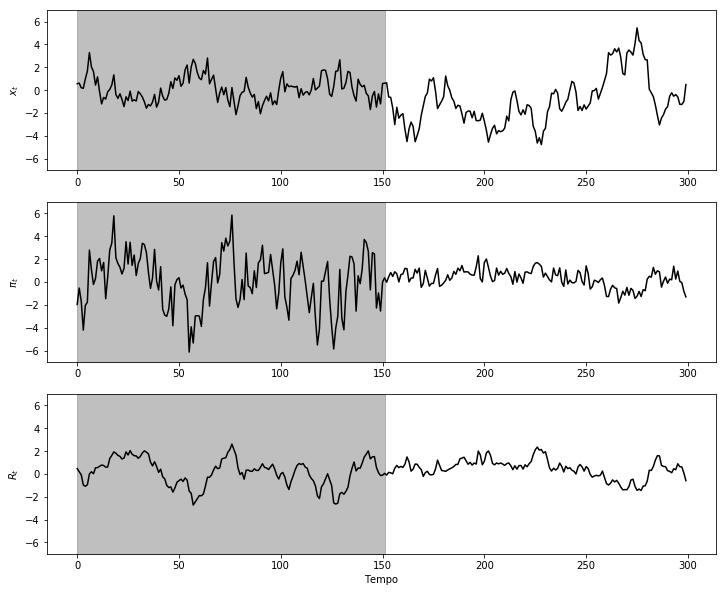

In [53]:
X = []
x=-1
for i in range(recordr1+1):
    x = x+1
    X.append(x)
    
X = np.array(X)


fig = plt.figure(figsize=(12,10))

p1 = fig.add_subplot(3, 1, 1) 
plt.plot(Xdata[0,1:], color="k")
plt.fill_between(X, -8, 8, color="grey", alpha=0.5)
plt.ylim(-7,7)
#plt.xlabel("Tempo")
plt.ylabel("$x_t$")

p2 = fig.add_subplot(3, 1, 2) 
plt.plot(Xdata[2,1:], color="k")
plt.fill_between(X, -8, 8, color="grey", alpha=0.5)
plt.ylim(-7,7)
#plt.xlabel("Tempo")
plt.ylabel("$\pi_t$")

p3 = fig.add_subplot(3, 1, 3) 
plt.plot(Xdata[4,1:], color="k")
plt.fill_between(X, -8, 8, color="grey", alpha=0.5)
plt.ylim(-7,7)
plt.xlabel("Tempo")
plt.ylabel("$R_t$")

plt.savefig("OnlyPolicyChange.pdf")